# PyClustafari Demonstrator

## Imports

In [1]:
import time

import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier

## Preperations

In [2]:
n_samples = 10000

X, y = make_classification(
    n_samples=n_samples,
    n_features=2,
    n_repeated=0,
    n_redundant=0,
    n_classes=4,
    n_clusters_per_class=1,
    random_state=42,
)
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

In [3]:
from typing import Literal

from matplotlib.axes import Axes

from clustafari import wrap_non_picklable_objects


@wrap_non_picklable_objects
def train(
    solver: Literal["lbfgs", "sgd", "adam"], learning_rate_init: float = 0.001
) -> tuple[np.ndarray, np.ndarray, float]:
    """Train a MLP classifier and return the predicted probabilities, predicted classes and accuracy."""
    mlp = MLPClassifier(
        solver=solver,
        learning_rate_init=learning_rate_init,
        hidden_layer_sizes=(100,),
        max_iter=5000,
        random_state=1,
    )
    mlp.fit(X_train, y_train)

    acc = float(mlp.score(X_test, y_test))
    p = mlp.predict_proba(X_test)
    y_ = mlp.predict(X_test)

    return p, y_, acc


def plot_data(data: np.ndarray, cls: np.ndarray, ax: Axes | None = None) -> Axes:
    """Return a scatter plot of the data colored by class."""
    if ax is None:
        _, ax = plt.subplots()

    sc = ax.scatter(x=data[:, 0], y=data[:, 1], c=cls, s=1, label=y)

    labels, counts = np.unique(cls, return_counts=True)
    labels = [f"{lbl}: {c}" for lbl, c in zip(labels, counts, strict=False)]
    ax.legend(sc.legend_elements()[0], labels, title="Classes")

    return ax


def plot_results(p: np.ndarray, y_: np.ndarray, acc: float, ax: Axes | None = None) -> Axes:
    """Plot the histogram of predicted probabilities for each class."""
    if ax is None:
        _, ax = plt.subplots()

    ax.set_title(f"Accuracy: {acc:.3f}")

    bins = 100
    for i in range(4):
        _, bins, _ = ax.hist(p[i].flatten(), label=i, bins=bins, alpha=0.6)  # type: ignore # ty:ignore[invalid-argument-type]  # noqa: PGH003

    labels, counts = np.unique(y_, return_counts=True)
    ax.legend(labels=[f"{lbl}: {c}" for lbl, c in zip(labels, counts, strict=False)])

    return ax

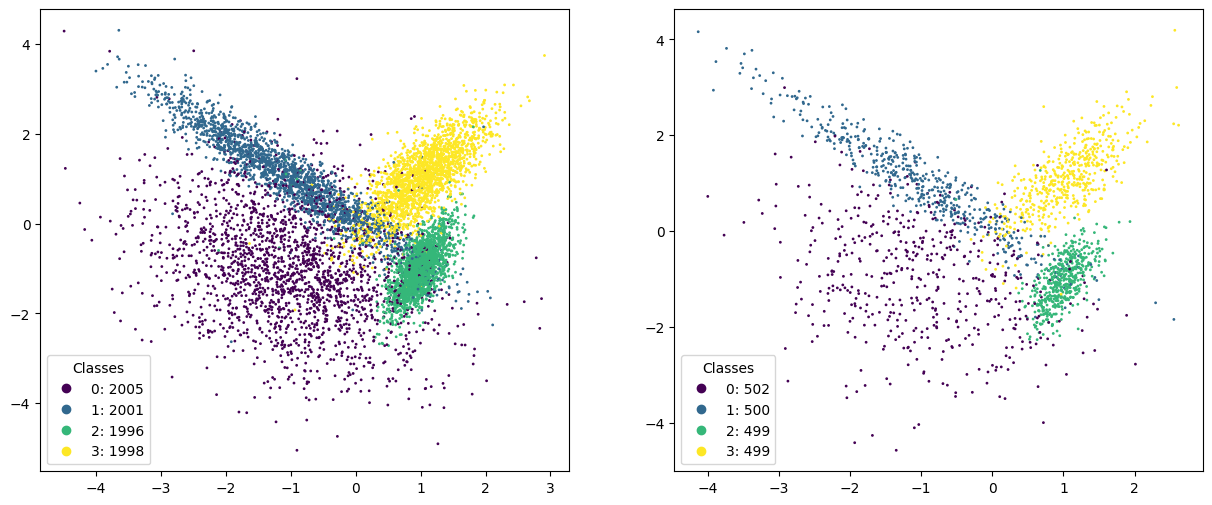

In [4]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(15, 6))
plot_data(X_train, y_train, ax1)
plot_data(X_test, y_test, ax2);

## Baseline

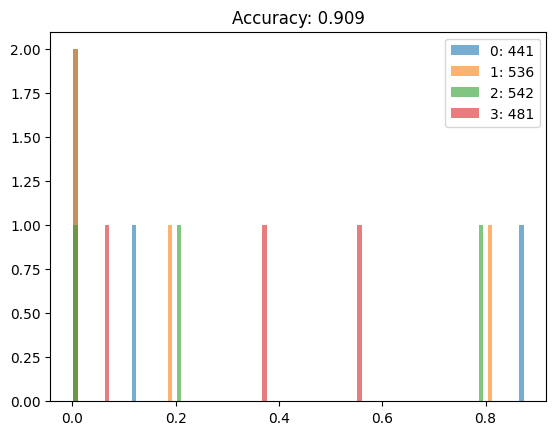

In [5]:
tick = time.monotonic_ns()
res = train("adam")
tock = time.monotonic_ns()

plot_results(*res);

## DummyRunner Example

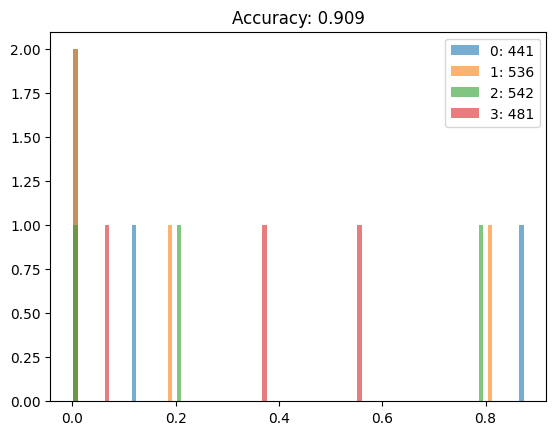

In [6]:
from clustafari import DummyConfig

tick = time.monotonic_ns()

cfg = DummyConfig()
runner = cfg.runner
res = runner.apply(train, "adam")

tock = time.monotonic_ns()

plot_results(*res);

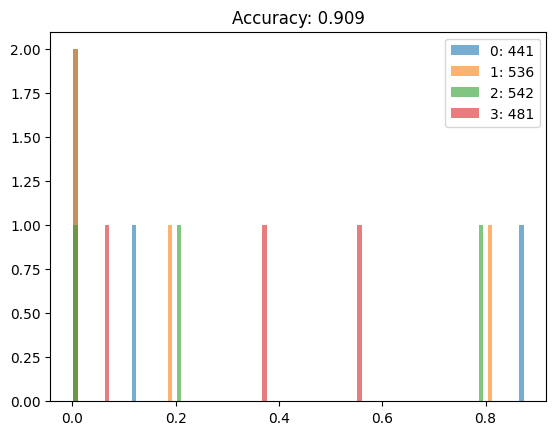

In [7]:
from clustafari import DummyConfig, delayed

delayed_function = delayed(train)("adam")

tick = time.monotonic_ns()

cfg = DummyConfig()
runner = cfg.runner
res = runner.apply(delayed_function)

tock = time.monotonic_ns()

plot_results(*res);

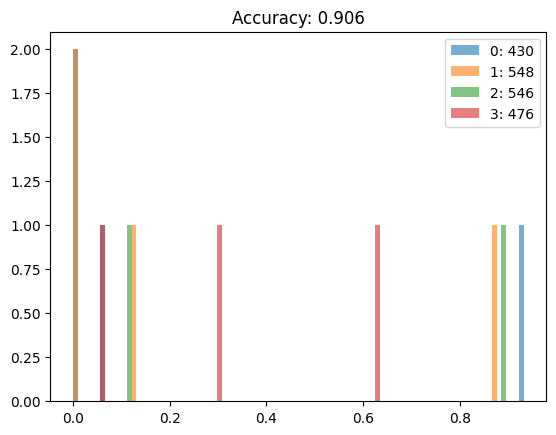

In [8]:
from clustafari import DummyConfig, delayed


@delayed
def custom_fn(solver: Literal["lbfgs", "sgd", "adam"]) -> tuple[np.ndarray, np.ndarray, float]:
    """Delaiing the training of the model."""
    return train(solver, learning_rate_init=0.01)


delayed_function = custom_fn("adam")

tick = time.monotonic_ns()

cfg = DummyConfig()
runner = cfg.runner
res = runner.apply(delayed_function)

tock = time.monotonic_ns()

plot_results(*res);

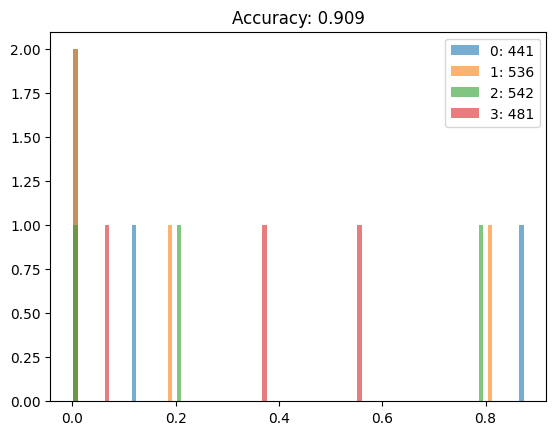

In [9]:
from clustafari import ClusterContext, DummyConfig

tick = time.monotonic_ns()

with ClusterContext(DummyConfig()) as ctx:
    res = ctx.apply(train, "adam")

tock = time.monotonic_ns()

plot_results(*res);

## Subprocess Example

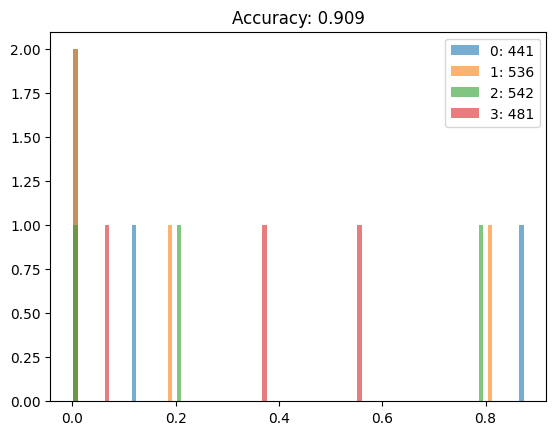

In [10]:
from clustafari import ClusterContext, SubprocessConfig

tick = time.monotonic_ns()

with ClusterContext(SubprocessConfig()) as ctx:
    res = ctx.apply(train, "adam")

tock = time.monotonic_ns()

plot_results(*res);

## Slurm Example

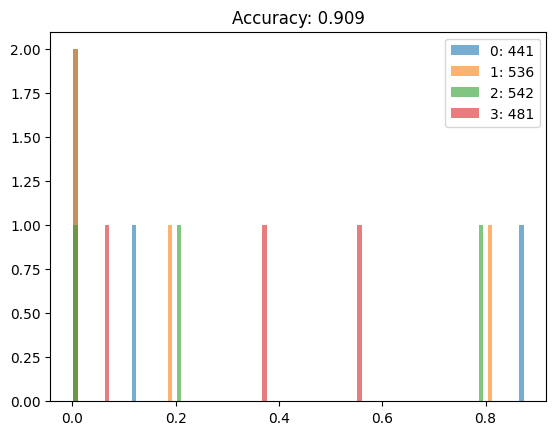

In [11]:
from clustafari import ClusterContext, SlurmConfig

tick = time.monotonic_ns()

with ClusterContext(SlurmConfig()) as ctx:
    res = ctx.apply(train, "adam")

tock = time.monotonic_ns()

plot_results(*res);

## Fit only

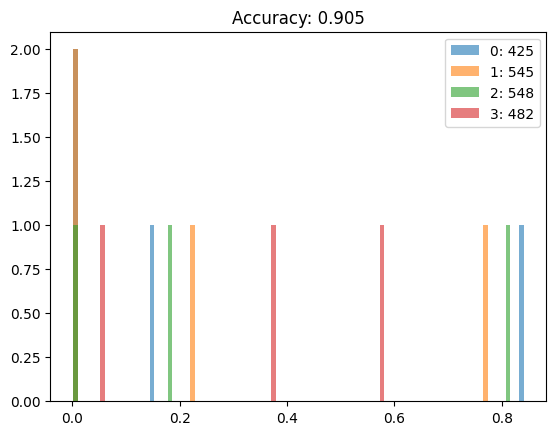

In [12]:
from clustafari import ClusterContext, SlurmConfig

clf = MLPClassifier(
    solver="adam",
    learning_rate_init=0.003,
    hidden_layer_sizes=(100,),
    max_iter=5000,
    random_state=1,
)

tick = time.monotonic_ns()

with ClusterContext(SlurmConfig()) as ctx:
    clf, _ = ctx.apply(clf.fit, X_train, y_train, return_object=True)

tock = time.monotonic_ns()


score = clf.score(X_test, y_test)
prop = clf.predict_proba(X_test)
pred = clf.predict(X_test)

plot_results(prop, pred, score);

## Mapping

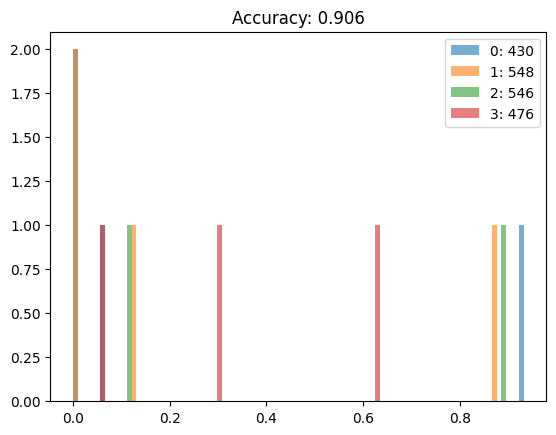

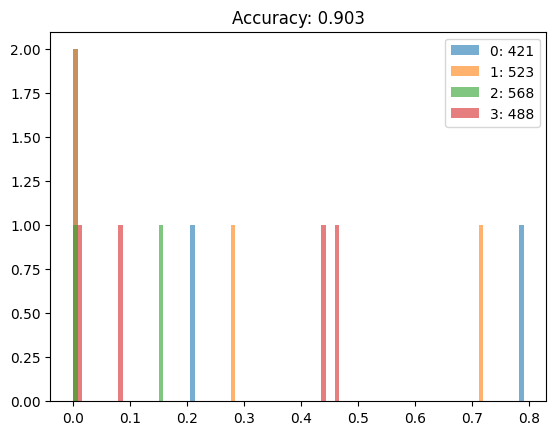

In [13]:
from clustafari import ClusterContext, SlurmConfig

tick = time.monotonic_ns()

with ClusterContext(SlurmConfig()) as ctx:
    res = ctx.map(
        train,
        args=[["adam"], ["sgd"]],
        kwargs=[{"learning_rate_init": 0.01}, {"learning_rate_init": 0.001}],
    )

tock = time.monotonic_ns()

[plot_results(*r) for r in res];

## Async

In [14]:
from clustafari import ClusterContext, SlurmConfig

tick = time.monotonic_ns()

with ClusterContext(SlurmConfig()) as ctx:
    run = ctx.apply_async(train, "adam")

tock = time.monotonic_ns()

In [15]:
f"Do stuff: {1234 * 1243}"

tock = time.monotonic_ns()

In [16]:
from clustafari.exceptions import RunnableStateError, TimeoutException

try:
    res = run.get()
    plot_results(*res)
except (RunnableStateError, TimeoutException):
    pass

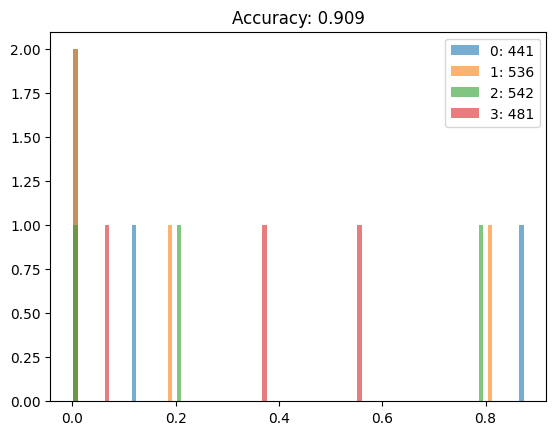

In [17]:
res = run.get(blocking=True)
plot_results(*res)

tock = time.monotonic_ns()

## Map async

In [18]:
from clustafari import ClusterContext, SlurmConfig

tick = time.monotonic_ns()

with ClusterContext(SlurmConfig()) as ctx:
    runs = ctx.map_async(
        train,
        args=[["adam"], ["sgd"]],
        kwargs=[{"learning_rate_init": 0.01}, {"learning_rate_init": 0.001}],
    )

tock = time.monotonic_ns()

In [19]:
tock = time.monotonic_ns()

In [20]:
from clustafari.exceptions import RunnableStateError, TimeoutException

try:
    res = [run.get() for run in runs]
    for r in res:
        plot_results(*r)
except (RunnableStateError, TimeoutException):
    pass

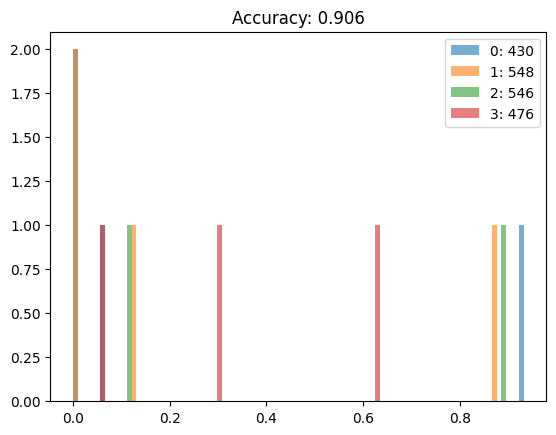

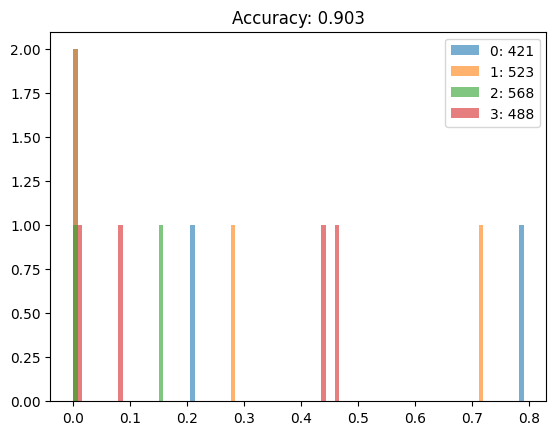

In [21]:
res = [run.get(blocking=True) for run in runs]
for r in res:
    plot_results(*r)

tock = time.monotonic_ns()

## Config

In [ ]:
from clustafari import SlurmConfig

SlurmConfig.get_config_names()

['CFG_CPU1_MEM8G',
 'CFG_CPU4_MEM8G',
 'CFG_CPU8_MEM32G',
 'CFG_CPU4_MEM8G_GPU1S',
 'CFG_CPU4_MEM8G_GPU2S',
 'CFG_CPU8_MEM32G_GPU2S',
 'CFG_CPU8_MEM32G_GPU1',
 'CFG_CPU8_MEM32G_GPU2']

In [23]:
cfg1 = SlurmConfig.get_config("CFG_CPU4_MEM8G_GPU2S")
cfg2 = SlurmConfig.CFG_CPU1_MEM8G  # ty:ignore[unresolved-attribute]
cfg3 = SlurmConfig.create_config(
    mem_per_node="4G",
    mem_per_cpu=None,
    mem_per_gpu=None,
    cpu_per_task=2,
    cpu_per_gpu=None,
    required_nodes=None,
    excluded_nodes=None,
    partition=None,
    generic_resource="shard:1",
    n_tasks=None,
    n_tasks_per_node=None,
    n_tasks_per_gpu=None,
    gpus=None,
    gpus_per_task=None,
    gpus_per_node=None,
)

cfg1, cfg2, cfg2

(lurmConfig({'memory_per_node': '8G', 'cpus_per_task': '4', 'gres_per_node': 'shard:2'}),
 lurmConfig({'memory_per_node': '8G', 'cpus_per_task': '1'}),
 lurmConfig({'memory_per_node': '8G', 'cpus_per_task': '1'}))

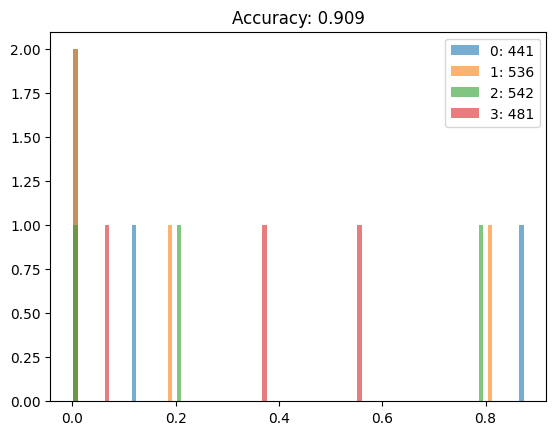

In [24]:
from clustafari import ClusterContext, SlurmConfig
from clustafari.resources import CPUPerTaskResource, MemoryPerNodeResource

cfg = SlurmConfig(
    CPUPerTaskResource(3),
    MemoryPerNodeResource("512M"),
)

tick = time.monotonic_ns()

with ClusterContext(cfg) as ctx:
    res = ctx.apply(train, "adam")

tock = time.monotonic_ns()

plot_results(*res);